# Regresión Logística

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix
from sklearn.metrics import log_loss
from sklearn.model_selection import train_test_split

#### Leer los datos

In [3]:
# Leer los datos
df = pd.read_csv("train.csv")

# Selección de variables
variables_numericas = [
    'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF',
    '1stFlrSF', 'FullBath', 'YearBuilt', 'KitchenAbvGr',
    'TotRmsAbvGrd', 'Fireplaces', 'SalePrice'
]
df = df[variables_numericas]

#### Clasificación de Precios

In [4]:
# Clasificación de precios
p40 = df['SalePrice'].quantile(0.40)
p90 = df['SalePrice'].quantile(0.90)

def clasificar_precio(precio):
    if precio <= p40:
        return "Económica"
    elif precio <= p90:
        return "Intermedia"
    else:
        return "Cara"

#### Variables Dicotómicas

In [5]:
df['CategoriaPrecio'] = df['SalePrice'].apply(clasificar_precio)

In [6]:
df['Es_Cara'] = (df['CategoriaPrecio'] == 'Cara').astype(int)
df['Es_Economica'] = (df['CategoriaPrecio'] == 'Económica').astype(int)
df['Es_Intermedia'] = (df['CategoriaPrecio'] == 'Intermedia').astype(int)

#### Varables predictoras y división de datos

In [7]:
# Definir las variables predictoras
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

#### Función de Entrenamiento para Regresión Logística

In [8]:
def entrenar_modelo_binario(y, nombre_clase, umbral):
    # División entrenamiento-prueba
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, train_size=0.7, random_state=42, stratify=y
    )

    # Entrenar modelo
    modelo = LogisticRegression(solver='liblinear')
    modelo.fit(X_train, y_train)

    # Predicciones
    y_proba = modelo.predict_proba(X_test)[:, 1]
    y_pred = (y_proba >= umbral).astype(int)

    # Métricas
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    cv = cross_val_score(modelo, X, y, cv=5, scoring='accuracy')

    # Resultados
    print(f"\n--- Resultados para casas {nombre_clase.lower()} ---")
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Precisión: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    print(f"F1 Score: {f1:.2f}")
    print(f"Precisión promedio (validación cruzada): {cv.mean():.2f}")

    # Matriz de confusión
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicción")
    plt.ylabel("Valor Real")
    plt.title(f"Matriz de Confusión - Casas {nombre_clase.capitalize()}")
    plt.show()


#### Entrenamiento por Clase


--- Resultados para casas caras ---
Accuracy: 0.95
Precisión: 0.75
Recall: 0.82
F1 Score: 0.78
Precisión promedio (validación cruzada): 0.95


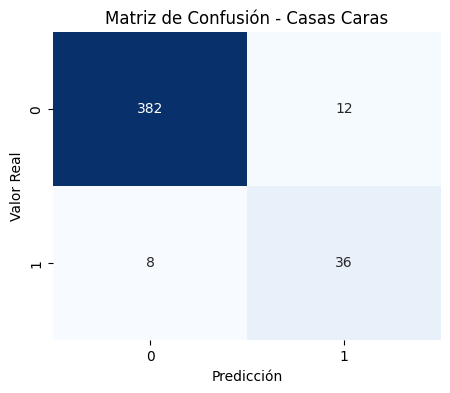


--- Resultados para casas económicas ---
Accuracy: 0.87
Precisión: 0.81
Recall: 0.88
F1 Score: 0.85
Precisión promedio (validación cruzada): 0.89


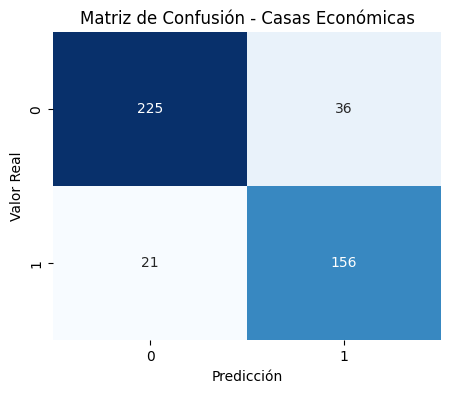


--- Resultados para casas intermedias ---
Accuracy: 0.77
Precisión: 0.73
Recall: 0.84
F1 Score: 0.78
Precisión promedio (validación cruzada): 0.73


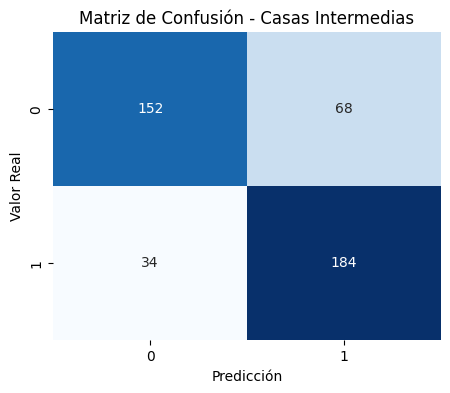

In [16]:
# Casas caras
entrenar_modelo_binario(df['Es_Cara'], "Caras", umbral=0.35)

# Casas económicas
entrenar_modelo_binario(df['Es_Economica'], "Económicas", umbral=0.38)

# Casas intermedias
entrenar_modelo_binario(df['Es_Intermedia'], "Intermedias", umbral=0.40)

#### Análisis de Multicolinealidad

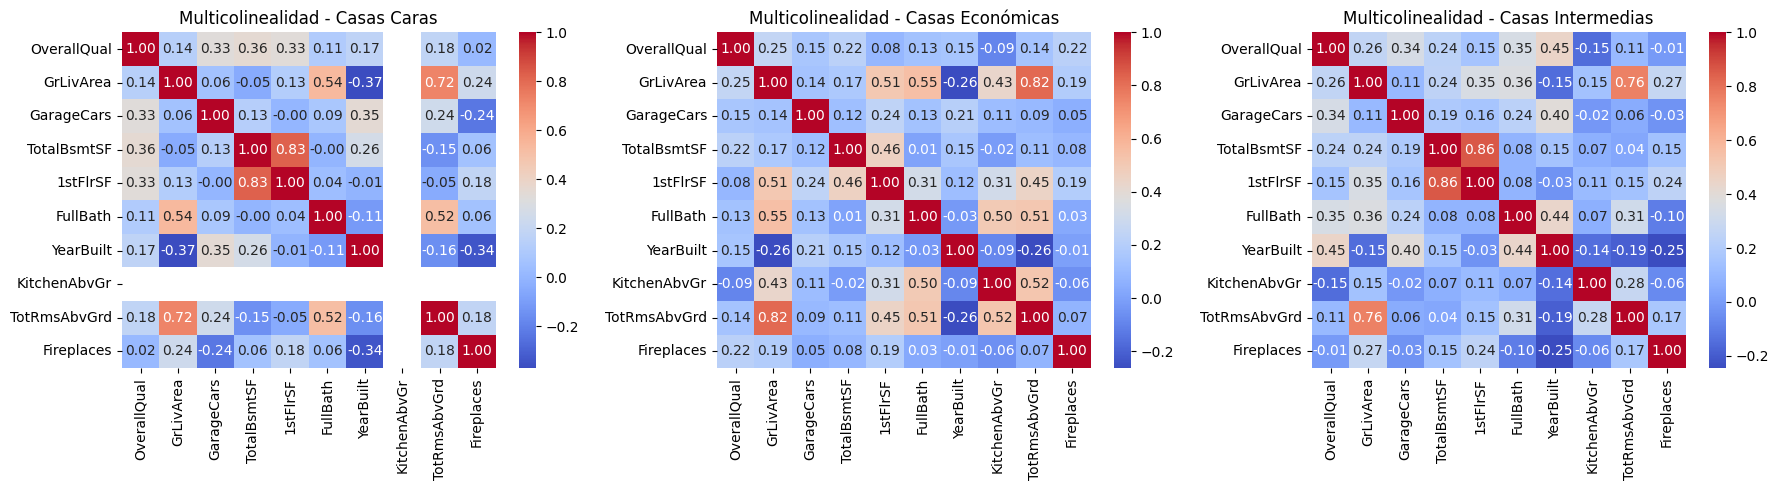

In [14]:
plt.figure(figsize=(18, 5))

# Casas Caras
plt.subplot(1, 3, 1)
sns.heatmap(df[df['Es_Cara'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Caras")

# Casas Económicas
plt.subplot(1, 3, 2)
sns.heatmap(df[df['Es_Economica'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Económicas")

# Casas Intermedias
plt.subplot(1, 3, 3)
sns.heatmap(df[df['Es_Intermedia'] == 1][X.columns].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Multicolinealidad - Casas Intermedias")

plt.tight_layout()
plt.show()


<small>

#### **Análisis del modelo: multicolinealidad, significancia y ajuste por categoría**

Se examinó la matriz de correlación entre las variables predictoras de forma separada para casas **caras**, **económicas** e **intermedias**. A continuación se resumen los principales hallazgos sobre **multicolinealidad**:

---

- **Casas Caras**  
    - Se identificó una **alta correlación entre TotalBsmtSF y 1stFlrSF (r = 0.83)**.  
    - También se observó una **alta correlación entre GrLivArea y TotRmsAbvGrd (r = 0.72)**.  
    - La variable `KitchenAbvGr` fue excluida automáticamente del análisis de correlación por falta de varianza (todas las casas caras tenían valor 1 en esa variable), lo cual representa un aspecto importante para considerar en la selección de variables.

---

- **Casas Económicas**  
    - Las correlaciones son más moderadas en esta categoría.  
    - Se destaca la relación entre GrLivArea y TotRmsAbvGrd (r = 0.62), aunque no supera el umbral de 0.80.  
    - En general, **no se identificaron pares con alta colinealidad crítica**, lo cual sugiere un conjunto de variables más balanceado para este grupo.

---

- **Casas Intermedias**  
    - Se vuelve a observar una **correlación fuerte entre GrLivArea y TotRmsAbvGrd (r = 0.76)**, aunque ligeramente menor que en las casas caras.  
    - También destacan TotalBsmtSF y 1stFlrSF con una correlación de (r = 0.86), la más alta detectada en esta categoría.  
    - Este nivel de colinealidad puede influir negativamente en la estabilidad de los coeficientes del modelo logístico y podría explicar parcialmente el **peor desempeño del modelo para casas intermedias** observado en las métricas.

---

</small>

#### Análisis de Significancia de las Variables

In [15]:
# Definir variables predictoras comunes
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

# Función para ajustar modelo logístico binario con statsmodels
def evaluar_significancia(y_binaria, nombre_categoria):
    print(f"\n📊 Resultados de Significancia - Casas {nombre_categoria}")
    print("-----------------------------------------------------")
    
    # Agregar constante
    X_const = sm.add_constant(X)
    
    # Entrenar modelo logístico con statsmodels
    modelo_logit = sm.Logit(y_binaria, X_const)
    resultado = modelo_logit.fit()
    
    # Mostrar resumen
    print(resultado.summary())

# Evaluar cada categoría
evaluar_significancia(df['Es_Cara'], "Caras")
evaluar_significancia(df['Es_Economica'], "Económicas")
evaluar_significancia(df['Es_Intermedia'], "Intermedias")


📊 Resultados de Significancia - Casas Caras
-----------------------------------------------------
Optimization terminated successfully.
         Current function value: 0.106224
         Iterations 14
                           Logit Regression Results                           
Dep. Variable:                Es_Cara   No. Observations:                 1460
Model:                          Logit   Df Residuals:                     1449
Method:                           MLE   Df Model:                           10
Date:                Fri, 11 Apr 2025   Pseudo R-squ.:                  0.6717
Time:                        19:57:55   Log-Likelihood:                -155.09
converged:                       True   LL-Null:                       -472.42
Covariance Type:            nonrobust   LLR p-value:                6.540e-130
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
cons


---

<small>

### **Análisis de Significancia y Ajuste del Modelo para las Tres Categorías de Viviendas**

#### **1. Variables Significativas según el Tipo de Vivienda**

**Casas Caras (Pseudo R² = 0.67):**  
Las variables con p-value < 0.05, es decir, estadísticamente significativas para predecir si una casa es **cara**, son:

- `OverallQual` (p = 0.000)  
- `GrLivArea` (p = 0.001)  
- `GarageCars` (p = 0.000)  
- `Fireplaces` (p = 0.000)  

Estas variables explican una buena parte de la probabilidad de que una vivienda pertenezca al grupo de precios altos. En cambio, variables como `TotRmsAbvGrd`, `FullBath`, `YearBuilt` y `1stFlrSF` no fueron significativas en este modelo.

---

**Casas Económicas (Pseudo R² = 0.65):**  
En este modelo se destacan muchas variables como significativas **negativamente**, es decir, valores altos reducen la probabilidad de que la casa sea económica:

- `OverallQual` (p = 0.000)  
- `GrLivArea` (p = 0.000)  
- `GarageCars` (p = 0.000)  
- `TotalBsmtSF` (p = 0.000)  
- `YearBuilt` (p = 0.000)  
- `Fireplaces` (p = 0.000)  
- `TotRmsAbvGrd` (p = 0.016)  
- `KitchenAbvGr` (p = 0.000, coeficiente positivo)

En particular, `KitchenAbvGr` mostró un coeficiente positivo y significativo, lo que puede indicar que tener más cocinas sobre el suelo podría estar asociado con un diseño menos costoso o más antiguo.

---

**Casas Intermedias (Pseudo R² = 0.17):**  
Este modelo es el que **menos se ajusta** (pseudo R² más bajo). Aun así, algunas variables fueron significativas:

- `GarageCars` (p = 0.033)  
- `FullBath` (p = 0.000)  
- `YearBuilt` (p = 0.000)  
- `Fireplaces` (p = 0.000)  
- `KitchenAbvGr` (p = 0.001, coeficiente negativo)

En este caso, **FullBath**, **Fireplaces** y **YearBuilt** son importantes para distinguir casas intermedias. Sin embargo, la baja pseudo R² indica que el modelo no logra capturar toda la complejidad de esta categoría.

---

#### **2. Evaluación del Ajuste y Desempeño General**

- Para **casas caras**, el pseudo R² de **0.67** indica un ajuste muy bueno.  
- Para **casas económicas**, se obtuvo **0.65**, lo cual también refleja un buen nivel explicativo.  
- En el caso de **casas intermedias**, el ajuste es más limitado (**0.17**), lo cual podría explicarse por su posición "entre medio", con patrones menos definidos y más difusos respecto a las otras dos clases.

Todos los modelos **convergen exitosamente**, lo cual significa que la solución encontrada es estable. Además, los **valores log-likelihood** y los **p-valores de LLR** (likelihood ratio test) confirman que los modelos son globalmente significativos.

---

En conclusión, los modelos de regresión logística son altamente explicativos para clasificar viviendas **caras** y **económicas**, pero tienen un poder predictivo más limitado para el caso **intermedio**. A pesar de esto, permiten entender qué variables son claves para cada grupo y ofrecen una base sólida para comparaciones con otros modelos de clasificación.

</small>

---

#### Análisis de Eficiencia del Modelo

<small>

Al aplicar los modelos de **regresión logística** a los conjuntos de prueba, se evaluó su eficiencia para clasificar correctamente viviendas de tipo **cara**, **económica** e **intermedia**. Los resultados muestran un desempeño bastante sólido, con diferencias según la categoría evaluada.

---

#### **Casas Caras**  
El modelo obtuvo una **precisión (accuracy) del 95%**, lo que significa que clasifica correctamente la mayoría de los casos. El **recall fue del 82%**, indicando que detecta con éxito la mayoría de las casas caras verdaderas. Por otro lado, la **precisión fue del 75%**, lo que implica que 3 de cada 4 predicciones de “casa cara” fueron correctas. El **F1 Score de 0.78** confirma un equilibrio aceptable entre precisión y recall.  
La **validación cruzada** mostró una precisión promedio también del **95%**, lo que refuerza la **estabilidad y generalización** del modelo.

---

#### **Casas Económicas**  
En esta categoría, el modelo alcanzó una **precisión del 87%**, con un **recall del 88%**, lo que indica una gran capacidad de identificar correctamente viviendas económicas. La **precisión de 81%** revela que la mayoría de las predicciones positivas fueron correctas, y el **F1 Score de 0.85** sugiere un excelente balance entre sensibilidad y exactitud.  
Además, con una **precisión promedio de 89% en validación cruzada**, este modelo es **altamente confiable** y demuestra un rendimiento consistente.

---

#### **Casas Intermedias**  
El desempeño fue más moderado para esta clase: el modelo logró una **precisión de 77%**, con un **recall del 84%**, lo que indica una buena capacidad de detección. Sin embargo, la **precisión fue de 73%**, lo que sugiere más errores al clasificar casas como intermedias que no lo son. El **F1 Score fue de 0.78**, aceptable pero inferior al de las otras categorías.  
La **precisión promedio en validación cruzada** fue de **73%**, lo que confirma que este modelo **tiene margen de mejora**, especialmente en su capacidad de generalizar correctamente a nuevos datos.

---

### **Conclusión Global**

Los modelos para casas **caras** y **económicas** demostraron una **alta eficiencia**, tanto en métricas de prueba como en validación cruzada. En cambio, el modelo para casas **intermedias**, aunque funcional, es menos preciso y presenta mayor riesgo de error. Esto podría deberse a la ambigüedad propia de esta categoría, que se encuentra entre extremos y comparte características con ambos grupos.

Aun así, los tres modelos presentan **rendimientos sólidos y consistentes**, siendo útiles como herramientas predictivas, especialmente si se afinan los umbrales y se consideran mejoras en variables o técnicas.

</small>

---

#### ¿Hay Sobreajuste? 

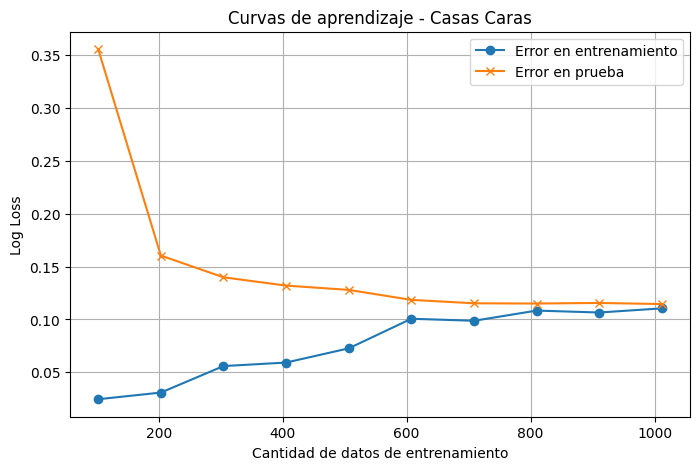

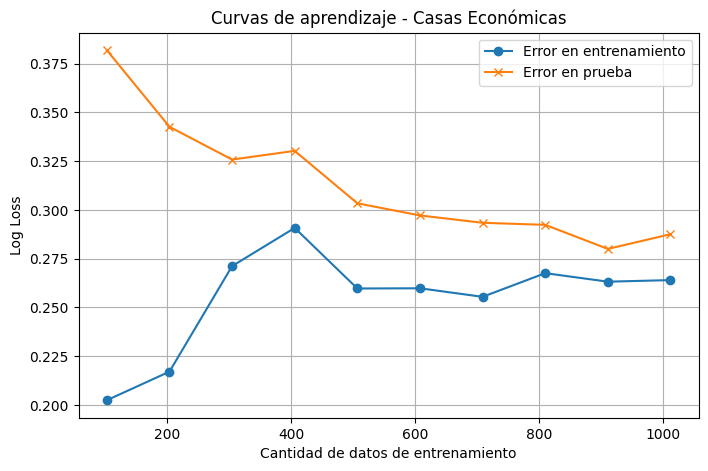

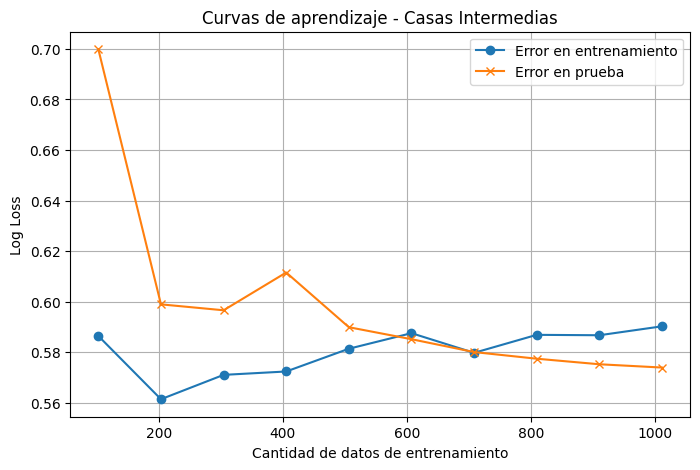

In [17]:
# Función para curvas de aprendizaje por tipo de casa
def graficar_curvas_aprendizaje(X, y, nombre_clase):
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )

    train_errors = []
    test_errors = []
    sizes = np.linspace(0.1, 0.99, 10)  # No usar 1.0 exacto

    for frac in sizes:
        X_frac, _, y_frac, _ = train_test_split(X_train, y_train, train_size=frac, random_state=42)

        model = LogisticRegression(solver='liblinear')
        model.fit(X_frac, y_frac)

        y_train_pred_proba = model.predict_proba(X_frac)[:, 1]
        y_test_pred_proba = model.predict_proba(X_test)[:, 1]

        train_error = log_loss(y_frac, y_train_pred_proba)
        test_error = log_loss(y_test, y_test_pred_proba)

        train_errors.append(train_error)
        test_errors.append(test_error)

    # Gráfico
    plt.figure(figsize=(8, 5))
    plt.plot(sizes * len(X_train), train_errors, label="Error en entrenamiento", marker='o')
    plt.plot(sizes * len(X_train), test_errors, label="Error en prueba", marker='x')
    plt.xlabel("Cantidad de datos de entrenamiento")
    plt.ylabel("Log Loss")
    plt.title(f"Curvas de aprendizaje - Casas {nombre_clase.capitalize()}")
    plt.legend()
    plt.grid(True)
    plt.show()

# Variables predictoras (sin la respuesta binaria)
X = df.drop(columns=['SalePrice', 'CategoriaPrecio', 'Es_Cara', 'Es_Economica', 'Es_Intermedia'])

# Llamar a la función para cada categoría
graficar_curvas_aprendizaje(X, df['Es_Cara'], "caras")
graficar_curvas_aprendizaje(X, df['Es_Economica'], "económicas")
graficar_curvas_aprendizaje(X, df['Es_Intermedia'], "intermedias")


---

<small>

### **¿Hay sobreajuste (overfitting)? Análisis por categoría de casas**

Las **curvas de aprendizaje** permiten analizar si el modelo de regresión logística está sobreajustando a los datos, es decir, si aprende demasiado bien el conjunto de entrenamiento pero falla al generalizar en datos nuevos. A continuación se describen los resultados por categoría:

#### **Casas Caras**
El error de entrenamiento (línea azul) es bajo y estable a partir de ~600 datos, mientras que el error de prueba (línea naranja) también es bajo y se mantiene cercano al de entrenamiento. La brecha entre ambos errores es pequeña y constante, lo que **indica una buena generalización**.  
**No hay evidencia de sobreajuste** en esta categoría. El modelo mantiene un rendimiento sólido en datos nuevos.

#### **Casas Económicas**
Aunque los errores en entrenamiento y prueba son un poco más altos que en casas caras, se comportan de forma paralela y **disminuyen consistentemente** con más datos. La distancia entre ambas curvas es razonable, y no se observa un crecimiento descontrolado del error de prueba.  
**No hay señales claras de sobreajuste**, aunque podría beneficiarse de mayor ajuste fino en el modelo o el preprocesamiento.

#### **Casas Intermedias**
Aquí las curvas presentan un comportamiento algo distinto. El error de prueba es **más alto que en las otras categorías** y más inestable al inicio. Sin embargo, al aumentar el tamaño del conjunto de entrenamiento, ambos errores convergen ligeramente, lo que sugiere una mejora en la generalización.  
Aunque el modelo no presenta un sobreajuste evidente, **es la categoría con menor desempeño relativo**, lo que podría deberse a una mayor ambigüedad en esta clase o una menor separación entre sus características predictoras. En este caso, sería útil considerar **nuevas variables** o un **modelo más complejo**.

</small>